In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import linregress 

Import packages


In [2]:
TEST_DIR_PATH = "data\csv" # Replace with the actual test directory name
RED_CSV_PATH = f"{TEST_DIR_PATH}/red_intensity_timeseries.csv"
GREEN_CSV_PATH = f"{TEST_DIR_PATH}/green_intensity_timeseries.csv"
BLUE_CSV_PATH = f"{TEST_DIR_PATH}/blue_intensity_timeseries.csv"

In [3]:
def load_and_prepare_data(file_path):
    """Loads a CSV, extracts pathlength columns, and calculates I0."""
    df = pd.read_csv(file_path)

    # Get pathlength columns (excluding 'elapsed_seconds')
    pathlength_cols = [col for col in df.columns if col.startswith('pathlength_')]

    # Convert pathlength column values from string to float
    # We will use these for plotting
    pathlength_values = np.array([float(col.replace('pathlength_', '')) for col in pathlength_cols])

    # I0 is the first row's intensity for each pathlength
    # Make sure to handle potential NaNs if the first row could have them
    I0 = df.iloc[0][pathlength_cols].values

    return df, pathlength_cols, pathlength_values, I0

# --- Load data for all colors ---
print(f"Loading data from: {RED_CSV_PATH}")
red_df, red_pathlength_cols, red_pathlength_values, I0_red = load_and_prepare_data(RED_CSV_PATH)
print(f"Loading data from: {GREEN_CSV_PATH}")
green_df, green_pathlength_cols, green_pathlength_values, I0_green = load_and_prepare_data(GREEN_CSV_PATH)
print(f"Loading data from: {BLUE_CSV_PATH}")
blue_df, blue_pathlength_cols, blue_pathlength_values, I0_blue = load_and_prepare_data(BLUE_CSV_PATH)
print("\nData Loading Complete. Starting Analysis...")
print(I0_blue)


Loading data from: data\csv/red_intensity_timeseries.csv
Loading data from: data\csv/green_intensity_timeseries.csv
Loading data from: data\csv/blue_intensity_timeseries.csv

Data Loading Complete. Starting Analysis...
[12311.77142857            nan 12300.8                   nan
 12273.37142857            nan 12251.42857143            nan
 12275.2                   nan 12258.74285714            nan
 12328.22857143            nan 12319.08571429            nan
 12375.77142857            nan 12428.8                   nan
 12426.97142857            nan 12410.51428571            nan
 12368.45714286            nan 12306.28571429            nan
 12324.57142857            nan 12288.                    nan
 12298.97142857            nan 12298.97142857            nan
 12322.74285714            nan 12284.34285714            nan
 12273.37142857            nan 12375.77142857            nan
 12439.77142857            nan 12439.77142857            nan
 12381.25714286            nan 12362.97142857    

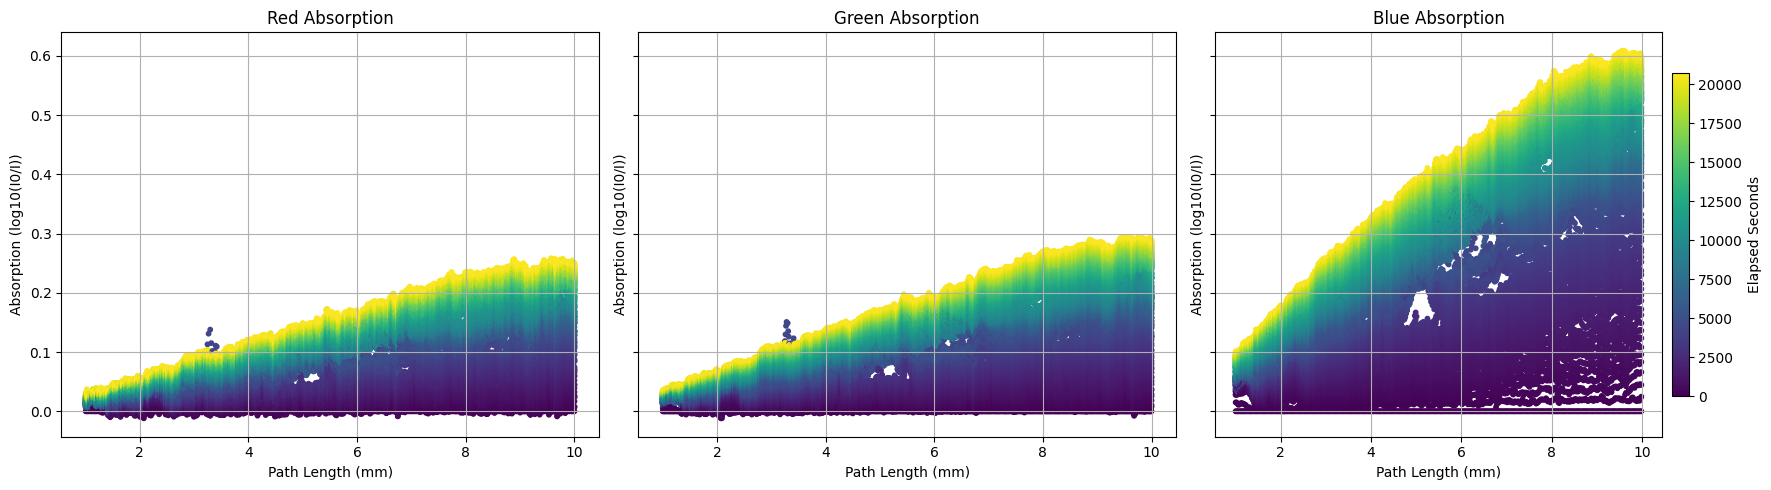

   elapsed_seconds       pathlength  absorption  pathlength_mm
0              0.0  pathlength_1.00    0.000000            1.0
1            150.0  pathlength_1.00    0.015028            1.0
2            300.0  pathlength_1.00    0.027629            1.0
3            450.0  pathlength_1.00    0.028799            1.0
4            600.0  pathlength_1.00    0.032676            1.0


In [4]:
def calculate_absorption(df, pathlength_cols, I0):
    """Calculates absorption log10(I0/I) for each pathlength."""
    # Calculate I for each pathlength
    I = df[pathlength_cols].values

    # Calculate absorption log10(I0/I)
    absorption = np.log10(I0 / I)

    # Create a new DataFrame to hold the absorption values
    absorption_df = pd.DataFrame(absorption, columns=pathlength_cols)
    absorption_df['elapsed_seconds'] = df['elapsed_seconds']

    return absorption_df


# Calculate absorption for all pathlengths
blue_absorption = calculate_absorption(blue_df, blue_pathlength_cols, I0_blue)
red_absorption = calculate_absorption(red_df, red_pathlength_cols, I0_red)
green_absorption = calculate_absorption(green_df, green_pathlength_cols, I0_green)

# Prepare data for scatter plot
# Melt the DataFrame to long format: each row = (elapsed_seconds, pathlength, absorption)
blue_long = blue_absorption.melt(id_vars='elapsed_seconds', 
                                  var_name='pathlength', 
                                  value_name='absorption')
red_long = red_absorption.melt(id_vars='elapsed_seconds', 
                                var_name='pathlength',
                                value_name='absorption')
green_long = green_absorption.melt(id_vars='elapsed_seconds',
                                    var_name='pathlength',
                                    value_name='absorption')


# Extract numeric pathlength in mm
blue_long['pathlength_mm'] = blue_long['pathlength'].str.replace('pathlength_', '').astype(float)
red_long['pathlength_mm'] = red_long['pathlength'].str.replace('pathlength_', '').astype(float)
green_long['pathlength_mm'] = green_long['pathlength'].str.replace('pathlength_', '').astype(float)

# Plot all three in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sc = None
for ax, long_df, color, title in zip(
    axes,
    [red_long, green_long, blue_long],
    ['red', 'green', 'blue'],
    ['Red', 'Green', 'Blue']
):
    sc = ax.scatter(
        long_df['pathlength_mm'],
        long_df['absorption'],
        c=long_df['elapsed_seconds'],
        cmap='viridis',
        s=10
    )
    ax.set_xlabel('Path Length (mm)')
    ax.set_ylabel('Absorption (log10(I0/I))')
    ax.set_title(f'{title} Absorption')
    ax.grid(True)

# Place the colorbar on the right of all subplots
cbar = fig.colorbar(sc, ax=axes[2], orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('Elapsed Seconds')

plt.tight_layout()
plt.show()

blue_long.to_csv('blue_long.csv', index=False)
print(blue_long.head())


In [5]:


# def slope_vs_time_df(long_df):
#     slope_vs_time = []
#     for t, group in long_df.groupby('elapsed_seconds'):
#         valid = group.dropna(subset=['absorption', 'pathlength_mm']) #remove NaN values
#         # Ensure we have enough data points to perform linear regression
#         if len(valid) > 10:
#             res = linregress(valid['pathlength_mm'], valid['absorption'])
#             slope_vs_time.append((t, res.slope))
#         else:
#             slope_vs_time.append((t, np.nan))
#     return pd.DataFrame(slope_vs_time, columns=['elapsed_seconds', 'slope'])

# # Calculate slope vs time for each channel
# red_slope = slope_vs_time_df(red_long)
# green_slope = slope_vs_time_df(green_long)
# blue_slope = slope_vs_time_df(blue_long)

# # Plot all three on the same figure
# plt.figure(figsize=(10, 6))
# plt.plot(red_slope['elapsed_seconds'], red_slope['slope'], color='red', label='Red')
# plt.plot(green_slope['elapsed_seconds'], green_slope['slope'], color='green', label='Green')
# plt.plot(blue_slope['elapsed_seconds'], blue_slope['slope'], color='blue', label='Blue')
# plt.xlabel('Elapsed Seconds')
# plt.ylabel('Slope (Extinction Coefficient x Concentration)')
# plt.title('Slope vs Time (All Channels)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()



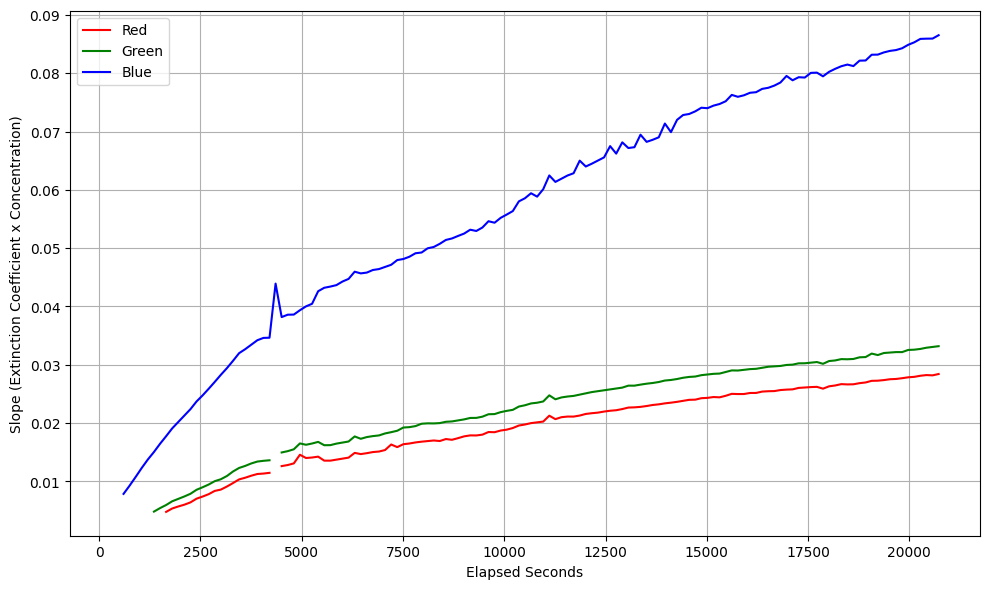

In [6]:
import numpy as np
import pandas as pd
from scipy import optimize

def precise_regression_without_intercept(x, y, force_positive_slope=True, r2_limit=0.8):
    """
    Perform linear regression without intercept (y = kx) and calculate R²
    based on the mean of y.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (pathlength)
    y : array-like
        y-coordinates (absorbance)
    force_positive_slope : bool
        If True, ensure the slope k is always positive
    r2_limit : float
        Minimum R² threshold for accepting results
        
    Returns:
    --------
    dict containing regression results
    """
    x = np.array(x)
    y = np.array(y)
    
    # Ensure data is sorted by x (from small to large)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    y = y[sort_indices]
    
    # Linear regression through the origin (no intercept)
    # Using the formula: k = sum(x*y) / sum(x²)
    numerator = np.sum(x * y)
    denominator = np.sum(x**2)
    
    if denominator != 0:
        slope = numerator / denominator
    else:
        slope = 0
        
    # Force positive slope if requested
    if force_positive_slope and slope <= 0:
        # If regression gives negative/zero slope, use optimization with constraint
        def sum_squared_residuals(params):
            k = params[0]
            y_pred = k * x
            return np.sum((y - y_pred) ** 2)
        
        # Initial parameter (small positive slope)
        initial_params = [0.0001]
        
        # Constraints: ensure k > 0
        constraints = [{'type': 'ineq', 'fun': lambda params: params[0]}]  # k > 0
        
        # Perform optimization
        result = optimize.minimize(sum_squared_residuals, initial_params, 
                                  constraints=constraints, 
                                  method='SLSQP')
        
        # Extract optimized parameter
        slope = result.x[0]
    
    # Predicted values
    y_pred = slope * x
    
    # Residuals
    residuals = y - y_pred
    
    # Calculate R² based on the mean of y
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    
    if ss_tot != 0:
        r_squared = 1 - (ss_res / ss_tot)
    else:
        r_squared = 0  # Avoid division by zero
    
    return {
        "slope": slope,
        "intercept": 0,  # Always zero for regression through origin
        "r_squared": r_squared,
        "residuals": residuals,
        "is_good_fit": r_squared > r2_limit
    }

def precise_decreasing_subset_regression(x, y, step_size=3, min_points=10, force_positive_slope=True, r2_limit=0.8):
    """
    Perform linear regression without intercept (y = kx) with gradually decreasing data size
    to find the subset with the best R² value.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (pathlength)
    y : array-like
        y-coordinates (absorbance)
    step_size : int
        Number of data points to decrease at each step
    min_points : int
        Minimum number of data points to consider for regression
    force_positive_slope : bool
        If True, ensure the slope k is always positive
    r2_limit : float
        Minimum R² threshold for accepting results
        
    Returns:
    --------
    dict containing results of the analysis with the best R² value, or None if no good fit found
    """
    x = np.array(x)
    y = np.array(y)
    
    # Ensure data is sorted by x (from small to large)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    y = y[sort_indices]
    
    # Check if there's enough data for the analysis
    if len(x) < min_points:
        return None
    
    # Track regression results for different ranges
    results_by_size = []
    
    # Calculate indices to evaluate (decreasing by step_size)
    # Start from full dataset, then decrease by step_size
    indices_to_check = list(range(len(x), min_points - 1, -step_size))
    
    # Make sure we include the smallest valid subset size
    if indices_to_check[-1] > min_points:
        indices_to_check.append(min_points)
    
    # Analyze each subset
    for i in indices_to_check:
        x_subset = x[:i]
        y_subset = y[:i]
        
        # Perform regression without intercept
        reg_result = precise_regression_without_intercept(x_subset, y_subset, force_positive_slope, r2_limit)
        
        # Store results for this subset
        subset_result = {
            "subset_size": i,
            "max_x": x_subset[-1],
            "slope": reg_result["slope"],
            "r_squared": reg_result["r_squared"],
            "residuals": reg_result["residuals"],
            "x_subset": x_subset,
            "y_subset": y_subset,
            "y_pred": reg_result["slope"] * x_subset,
            "is_good_fit": reg_result["is_good_fit"]
        }
        
        results_by_size.append(subset_result)
    
    # Find the subset with the best R² value
    if results_by_size:
        best_result = max(results_by_size, key=lambda x: x["r_squared"])
        
        # Add all results to the best result for reference
        best_result["all_results"] = results_by_size
        
        return best_result
    else:
        return None

def precise_slope_vs_time_df(long_df, force_positive_slope=True, use_subset_optimization=True, 
                            step_size=3, min_points=10, r2_limit=0.8):
    """
    Calculate slope vs time using precise regression methods.
    
    Parameters:
    -----------
    long_df : pandas.DataFrame
        DataFrame with columns: 'elapsed_seconds', 'absorption', 'pathlength_mm'
    force_positive_slope : bool
        If True, ensure the slope k is always positive
    use_subset_optimization : bool
        If True, use decreasing subset regression to find optimal fit
    step_size : int
        Number of data points to decrease at each step (only used if use_subset_optimization=True)
    min_points : int
        Minimum number of data points to consider for regression
    r2_limit : float
        Minimum R² threshold for accepting results
        
    Returns:
    --------
    pandas.DataFrame with columns: 'elapsed_seconds', 'slope'
    Same format as the original function
    """
    slope_vs_time = []
    
    for t, group in long_df.groupby('elapsed_seconds'):
        valid = group.dropna(subset=['absorption', 'pathlength_mm'])  # remove NaN values
        
        # Ensure we have enough data points to perform linear regression
        if len(valid) > min_points:
            x = valid['pathlength_mm'].values
            y = valid['absorption'].values
            
            try:
                if use_subset_optimization:
                    # Use the precise decreasing subset regression
                    reg_result = precise_decreasing_subset_regression(
                        x, y, 
                        step_size=step_size, 
                        min_points=min_points,
                        force_positive_slope=force_positive_slope,
                        r2_limit=r2_limit
                    )
                    
                    if reg_result is not None and reg_result["is_good_fit"]:
                        slope_vs_time.append((t, reg_result["slope"]))
                    else:
                        slope_vs_time.append((t, np.nan))
                else:
                    # Use the basic precise regression
                    reg_result = precise_regression_without_intercept(
                        x, y, 
                        force_positive_slope=force_positive_slope,
                        r2_limit=r2_limit
                    )
                    
                    if reg_result["is_good_fit"]:
                        slope_vs_time.append((t, reg_result["slope"]))
                    else:
                        slope_vs_time.append((t, np.nan))
                        
            except Exception as e:
                print(f"Error processing time {t}: {e}")
                slope_vs_time.append((t, np.nan))
        else:
            slope_vs_time.append((t, np.nan))
    
    return pd.DataFrame(slope_vs_time, columns=['elapsed_seconds', 'slope'])

# Example usage (replace your original function calls with these):
red_slope = precise_slope_vs_time_df(red_long)
green_slope = precise_slope_vs_time_df(green_long)
blue_slope = precise_slope_vs_time_df(blue_long)

plt.figure(figsize=(10, 6))
plt.plot(red_slope['elapsed_seconds'], red_slope['slope'], color='red', label='Red')
plt.plot(green_slope['elapsed_seconds'], green_slope['slope'], color='green', label='Green')
plt.plot(blue_slope['elapsed_seconds'], blue_slope['slope'], color='blue', label='Blue')
plt.xlabel('Elapsed Seconds')
plt.ylabel('Slope (Extinction Coefficient x Concentration)')
# plt.title('Slope vs Time (All Channels)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


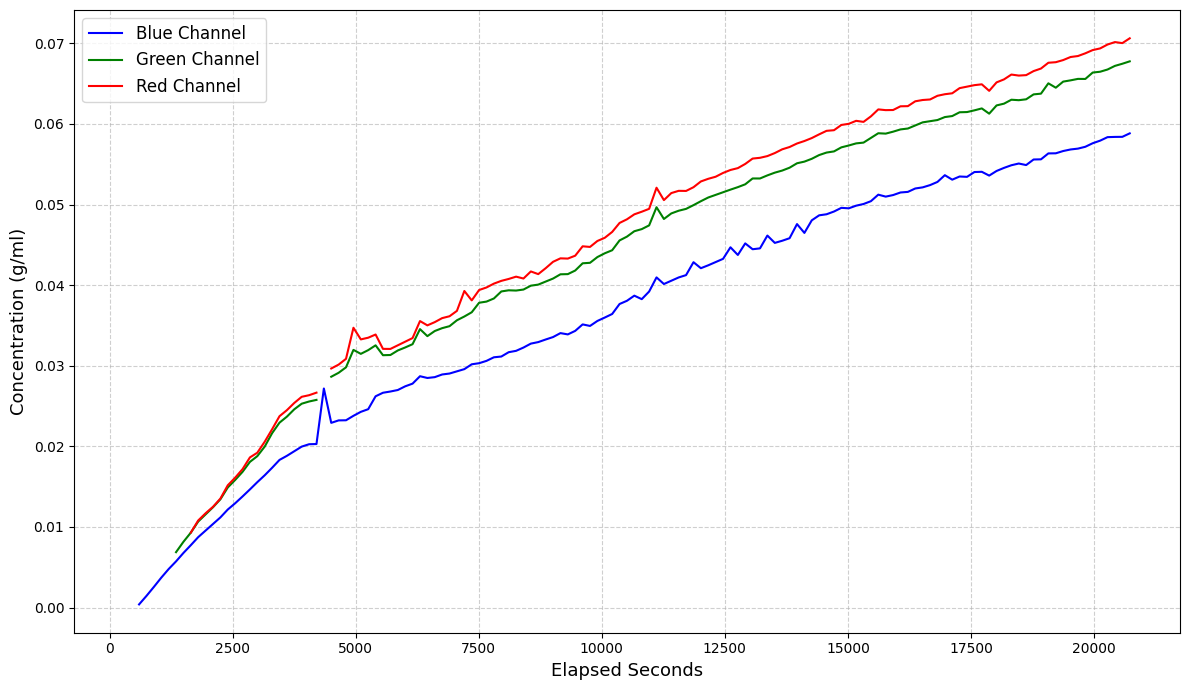

In [7]:

def concentration_from_slope_blue(slope, b=1.345725):

    return (np.array(slope) / b) - 0.005457



def concentration_from_slope_green(slope, g=0.465778):
    
    return (np.array(slope) / g) - 0.003492

def concentration_from_slope_red(slope, r=0.385434):

    return (np.array(slope) / r) - 0.0031

def plot_concentration_over_time_all_channels(blue_slope, green_slope, red_slope):
    """
    Plots concentration over time for all three channels (Blue, Green, Red) on the same figure.
    Uses the provided calibration functions for each channel.
    """
    # Calculate concentrations
    blue = blue_slope.copy()
    green = green_slope.copy()
    red = red_slope.copy()
    blue['concentration'] = concentration_from_slope_blue(blue['slope'])
    green['concentration'] = concentration_from_slope_green(green['slope'])
    red['concentration'] = concentration_from_slope_red(red['slope'])

    plt.figure(figsize=(12, 7))
    plt.plot(blue['elapsed_seconds'], blue['concentration'], color='blue', label='Blue Channel')
    plt.plot(green['elapsed_seconds'], green['concentration'], color='green', label='Green Channel')
    plt.plot(red['elapsed_seconds'], red['concentration'], color='red', label='Red Channel')

    plt.xlabel('Elapsed Seconds', fontsize=13)
    plt.ylabel('Concentration (g/ml)', fontsize=13)
    # plt.title('Concentration vs Time (All Channels)', fontsize=15, fontweight='bold')
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Usage:
plot_concentration_over_time_all_channels(blue_slope, green_slope, red_slope) 
